# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [2]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/Combine_Control_Monday-WorkingHours_training_21/result-lstm-tcp21-hl2-seq2-do0.2-oov3000-Tuesday-WorkingHours_testing_21.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'], sep=",")

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')


In [3]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.51-49810-192.168.10.50-21-tcp,0.735632,1,1,1,21528.364706,0,1,1
1,192.168.10.9-1065-192.168.10.50-21-tcp,0.724138,1,1,1,29350.447059,0,1,1
2,192.168.10.14-49496-192.168.10.50-21-tcp,0.724138,1,1,1,22743.882353,0,1,1
3,192.168.10.16-53770-192.168.10.50-21-tcp,0.724138,1,1,1,21414.505882,0,1,1
4,192.168.10.5-49221-192.168.10.50-21-tcp,0.735632,1,1,1,25553.223529,0,1,1


In [4]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.5-88-49182-6,192.168.10.5,49182,192.168.10.3,88,6,4/7/2017 8:54,640,7,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.5-88-49183-6,192.168.10.5,49183,192.168.10.3,88,6,4/7/2017 8:54,900,9,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.3-192.168.10.5-88-49184-6,192.168.10.5,49184,192.168.10.3,88,6,4/7/2017 8:54,1205,7,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.5-88-49185-6,192.168.10.5,49185,192.168.10.3,88,6,4/7/2017 8:54,511,7,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.5-88-49186-6,192.168.10.5,49186,192.168.10.3,88,6,4/7/2017 8:54,773,9,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [5]:
df_truth[[' Label']].value_counts()

 Label     
BENIGN         432074
FTP-Patator      7938
SSH-Patator      5897
Name: count, dtype: int64

In [6]:
df_pred[['b_iqr']].value_counts()

b_iqr
1        4473
Name: count, dtype: int64

## Exploratory Data Analysis

In [7]:
df_pred[['b_iqr']].value_counts()

b_iqr
1        4473
Name: count, dtype: int64

In [8]:
df_pred[['b_zscore']].value_counts()

b_zscore
1           4473
Name: count, dtype: int64

In [9]:
df_truth.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [10]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445909 entries, 0 to 445908
Data columns (total 85 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow_ID                      445909 non-null  object 
 1   Source_IP                    445909 non-null  object 
 2   Source_Port                  445909 non-null  int64  
 3   Destination_IP               445909 non-null  object 
 4   Destination_Port             445909 non-null  int64  
 5   Protocol                     445909 non-null  int64  
 6   Timestamp                    445909 non-null  object 
 7   Flow_Duration                445909 non-null  int64  
 8   Total_Fwd_Packets            445909 non-null  int64  
 9   Total_Backward_Packets       445909 non-null  int64  
 10  Total_Length_of_Fwd_Packets  445909 non-null  int64  
 11  Total_Length_of_Bwd_Packets  445909 non-null  float64
 12  Fwd_Packet_Length_Max        445909 non-null  int64  
 13 

In [11]:
df_truth['Label'].head()

0    BENIGN
1    BENIGN
2    BENIGN
3    BENIGN
4    BENIGN
Name: Label, dtype: object

In [12]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')
df_truth.dropna(subset=['Protocol'], inplace=True)  # Drop rows with missing protocol
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)  # Convert to string form

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_218459/812907933.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


## Making Predictions

In [13]:
df_pred["id"]

0       192.168.10.51-49810-192.168.10.50-21-tcp
1         192.168.10.9-1065-192.168.10.50-21-tcp
2       192.168.10.14-49496-192.168.10.50-21-tcp
3       192.168.10.16-53770-192.168.10.50-21-tcp
4        192.168.10.5-49221-192.168.10.50-21-tcp
                          ...                   
4468     192.168.10.8-57484-192.168.10.50-21-tcp
4469    192.168.10.51-57748-192.168.10.50-21-tcp
4470    192.168.10.17-52758-192.168.10.50-21-tcp
4471    192.168.10.25-64450-192.168.10.50-21-tcp
4472    192.168.10.15-59671-192.168.10.50-21-tcp
Name: id, Length: 4473, dtype: object

In [14]:
df_truth["id"]

# df_truth[df_truth["id"] == "192.168.10.50-21-172.16.0.1-52120-tcp"]

0           192.168.10.5-49182-192.168.10.3-88-tcp
1           192.168.10.5-49183-192.168.10.3-88-tcp
2           192.168.10.5-49184-192.168.10.3-88-tcp
3           192.168.10.5-49185-192.168.10.3-88-tcp
4           192.168.10.5-49186-192.168.10.3-88-tcp
                            ...                   
445904     192.168.10.14-51694-192.168.10.3-53-udp
445905     192.0.77.32-443-192.168.10.15-59317-tcp
445906     192.168.10.50-62256-192.168.10.3-53-udp
445907    52.84.145.70-443-192.168.10.25-54726-tcp
445908      192.168.10.9-51801-192.168.10.3-53-udp
Name: id, Length: 445909, dtype: object

In [15]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [ ]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [17]:
print(df_pred['Label'].unique())

[0 1]


In [18]:
# df_pred[df_pred['Label'] == 1].to_csv('filtered_prediction-1-21.csv', index=False)

df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
35,172.16.0.1-52108-192.168.10.50-21-tcp,0.666667,1,1,1,344142.392857,1,1,1,1
36,172.16.0.1-52108-192.168.10.50-21-tcp,0.666667,1,1,1,344142.392857,1,1,1,1
37,172.16.0.1-52108-192.168.10.50-21-tcp,0.666667,1,1,1,344142.392857,1,1,1,1
38,172.16.0.1-52124-192.168.10.50-21-tcp,0.757576,1,1,1,37361.516129,0,1,1,1
39,172.16.0.1-52124-192.168.10.50-21-tcp,0.757576,1,1,1,37361.516129,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
8035,172.16.0.1-60142-192.168.10.50-21-tcp,0.777778,1,1,1,160465.500000,1,1,1,1
8036,172.16.0.1-60140-192.168.10.50-21-tcp,0.756757,1,1,1,34287.342857,0,1,1,1
8037,172.16.0.1-60144-192.168.10.50-21-tcp,0.771429,1,1,1,45786.303030,0,1,1,1
8038,172.16.0.1-60126-192.168.10.50-21-tcp,0.814815,1,1,1,45822.849057,0,1,1,1


In [19]:
# df_pred[df_pred['Label'] == 0].to_csv('filtered_predictions-0-21.csv', index=False)

df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.51-49810-192.168.10.50-21-tcp,0.735632,1,1,1,21528.364706,0,1,1,0
1,192.168.10.51-49810-192.168.10.50-21-tcp,0.735632,1,1,1,21528.364706,0,1,1,0
2,192.168.10.9-1065-192.168.10.50-21-tcp,0.724138,1,1,1,29350.447059,0,1,1,0
3,192.168.10.9-1065-192.168.10.50-21-tcp,0.724138,1,1,1,29350.447059,0,1,1,0
4,192.168.10.14-49496-192.168.10.50-21-tcp,0.724138,1,1,1,22743.882353,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
8974,192.168.10.25-64450-192.168.10.50-21-tcp,0.724138,1,1,1,20828.941176,0,1,1,0
8975,192.168.10.25-64450-192.168.10.50-21-tcp,0.724138,1,1,1,20828.941176,0,1,1,0
8976,192.168.10.15-59671-192.168.10.50-21-tcp,0.724138,1,1,1,17855.364706,0,1,1,0
8977,192.168.10.15-59671-192.168.10.50-21-tcp,0.724138,1,1,1,17855.364706,0,1,1,0


In [20]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.51-49810-192.168.10.50-21-tcp,0.735632,1,1,1,21528.364706,0,1,1,0
1,192.168.10.51-49810-192.168.10.50-21-tcp,0.735632,1,1,1,21528.364706,0,1,1,0
2,192.168.10.9-1065-192.168.10.50-21-tcp,0.724138,1,1,1,29350.447059,0,1,1,0
3,192.168.10.9-1065-192.168.10.50-21-tcp,0.724138,1,1,1,29350.447059,0,1,1,0
4,192.168.10.14-49496-192.168.10.50-21-tcp,0.724138,1,1,1,22743.882353,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
8974,192.168.10.25-64450-192.168.10.50-21-tcp,0.724138,1,1,1,20828.941176,0,1,1,0
8975,192.168.10.25-64450-192.168.10.50-21-tcp,0.724138,1,1,1,20828.941176,0,1,1,0
8976,192.168.10.15-59671-192.168.10.50-21-tcp,0.724138,1,1,1,17855.364706,0,1,1,0
8977,192.168.10.15-59671-192.168.10.50-21-tcp,0.724138,1,1,1,17855.364706,0,1,1,0


In [21]:
df_pred[['Label']].value_counts()

Label
1        7920
0        1059
Name: count, dtype: int64

In [22]:
df_pred['b_zscore'].unique()

array([1])

In [23]:
import os
# Define the directory path
dir_path = '../mcnemar/ftp'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [24]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [25]:
df_pred[['b_zscore']]

,b_zscore
0,1
1,1
2,1
3,1
4,1
...,...
8974,1
8975,1
8976,1
8977,1


### Detection Rate

In [26]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 1.0
Recall-Binary-b_iqr: 1.0
Recall-Binary-b_zscore: 1.0
Recall-Floating-f_mean: 0.5559343434343434
Recall-Floating-f_iqr: 1.0
Recall-Floating-f_zscore: 1.0


### Confussion Matrix

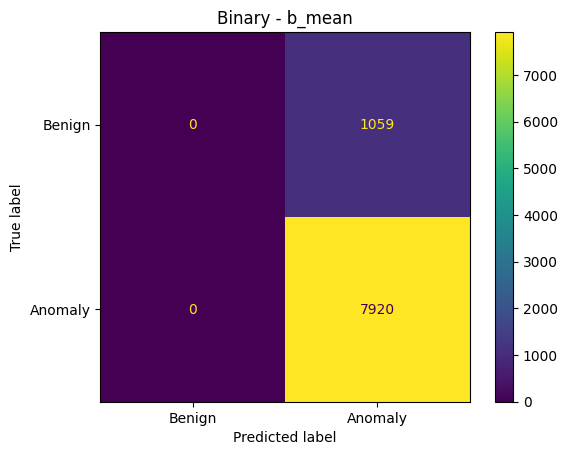

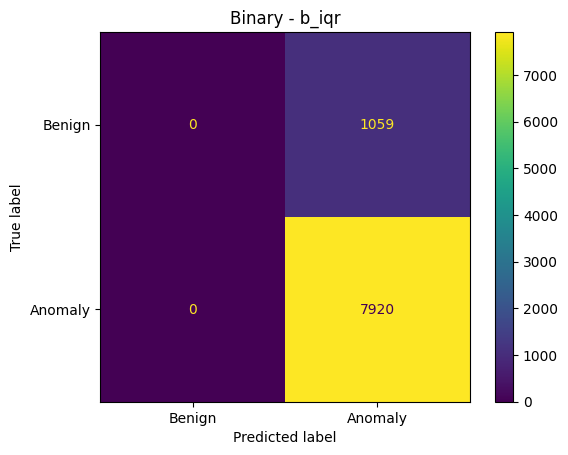

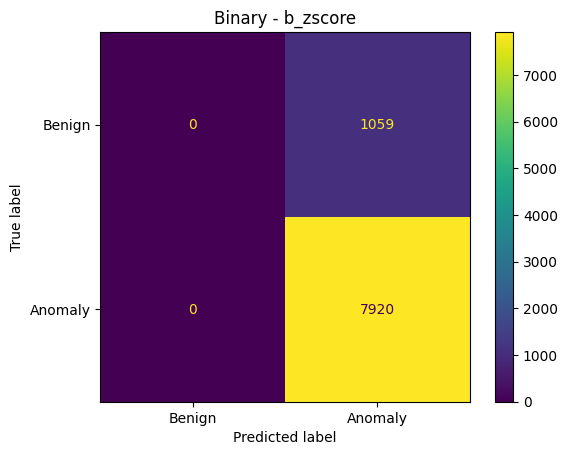

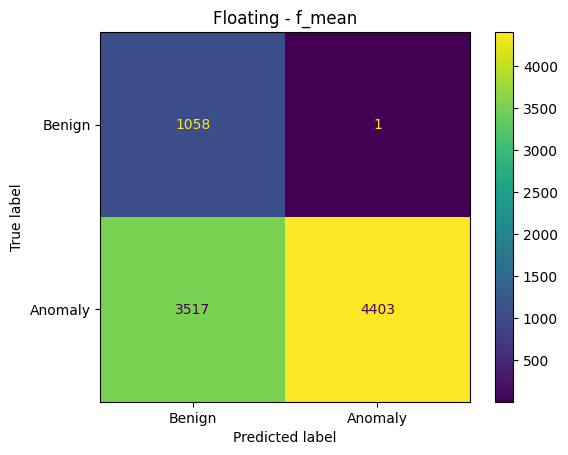

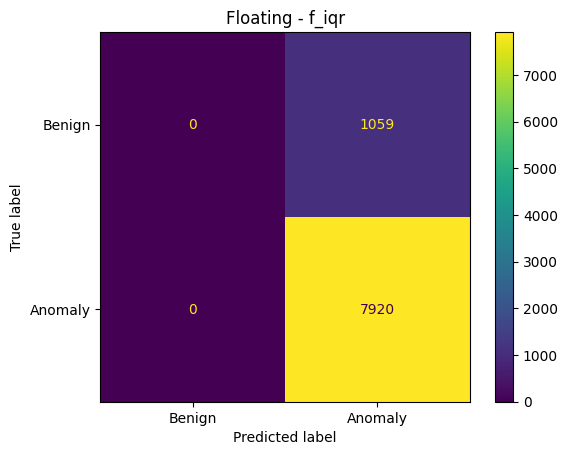

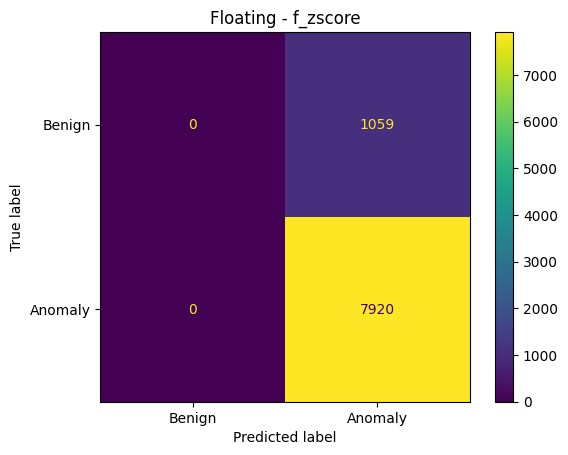

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [28]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

F2-Binary-b_mean: 0.9739541061019701
F2-Binary-b_iqr: 0.9739541061019701
F2-Binary-b_zscore: 0.9739541061019701
F2-Floating-f_mean: 0.610104201308059
F2-Floating-f_iqr: 0.9739541061019701
F2-Floating-f_zscore: 0.9739541061019701


### FPR Score

In [29]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

FPR-Binary-b_mean: 1.0
FPR-Binary-b_iqr: 1.0
FPR-Binary-b_zscore: 1.0
FPR-Floating-f_mean: 0.0009442870632672333
FPR-Floating-f_iqr: 1.0
FPR-Floating-f_zscore: 1.0


In [30]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 0.8820581356498497
Accuracy-Binary-b_iqr: 0.8820581356498497
Accuracy-Binary-b_zscore: 0.8820581356498497
Accuracy-Floating-f_mean: 0.6081969038868471
Accuracy-Floating-f_iqr: 0.8820581356498497
Accuracy-Floating-f_zscore: 0.8820581356498497


In [31]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,1.000000,0.973954,1.000000,0.882058
b_iqr,1.000000,0.973954,1.000000,0.882058
b_zscore,1.000000,0.973954,1.000000,0.882058
f_mean,0.555934,0.610104,0.000944,0.608197
f_iqr,1.000000,0.973954,1.000000,0.882058
f_zscore,1.000000,0.973954,1.000000,0.882058


In [32]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [33]:
# %pip install openpyxl